# EDA

This first step is focused on boiling the corpus down to a digestible format that can be handled by nlp paradigms.



In [26]:
import pandas as pd
import numpy as np
import openai
import re
import os
import glob
import json
import seaborn as sns
import matplotlib.pyplot as plt

## Loading and Cleaning 

In [27]:
import re
import glob
import json
from tqdm import tqdm
import re

def clean_text(text):
    text = text.lower()
    
    # Remove line breaks
    text = text.replace("\n", " ").replace("\r", " ")
    
    # Remove sequences of special characters longer than 3
    text = re.sub(r"[^\w\s]{4,}", " ", text)
    
    # Keep only Armenian letters, spaces, and sentence-ending punctuation
    text = re.sub(r"[^\u0530-\u058F\s\.!\?]", " ", text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text).strip()
    
    return text



def corpus_formation(input_dir, output_file):
    files = glob.glob(f"{input_dir}/*.txt")
    page_pattern = re.compile(r"---\s*Page\s*(\d+)\s*---", re.IGNORECASE)
    
    with open(output_file, "w", encoding="utf-8") as out_f:
        for file_path in tqdm(files, desc="Processing files"):
            file_name = os.path.splitext(os.path.basename(file_path))[0]
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read()
            
            splits = page_pattern.split(text)
            
            for i in range(1, len(splits), 2):
                page_number = splits[i].strip()
                page_text = splits[i+1].strip()
                cleaned = clean_text(page_text)
                
                json_line = json.dumps({
                    "file_name": file_name,
                    "page_number": page_number,
                    "cleaned_text": cleaned
                }, ensure_ascii=False)
                
                out_f.write(json_line + "\n")
    
    print(f"JSONL file created: {output_file}")


In [28]:
corpus_formation("C:/Users/Kamal/OneDrive/Desktop/PDS/corpus_txt",'corpus.jsonl')

Processing files: 100%|██████████| 36/36 [00:02<00:00, 14.29it/s]

JSONL file created: corpus.jsonl


# Studying and Filtering

In [29]:
corpus=pd.read_json('corpus.jsonl',lines=True)
corpus.head()

,file_name,page_number,cleaned_text
0,Divan_Prak10,1,ե ա բ
1,Divan_Prak10,2,
2,Divan_Prak10,3,
3,Divan_Prak10,4,
4,Divan_Prak10,5,


## Empty text filtration

<Axes: xlabel='text_length', ylabel='Count'>

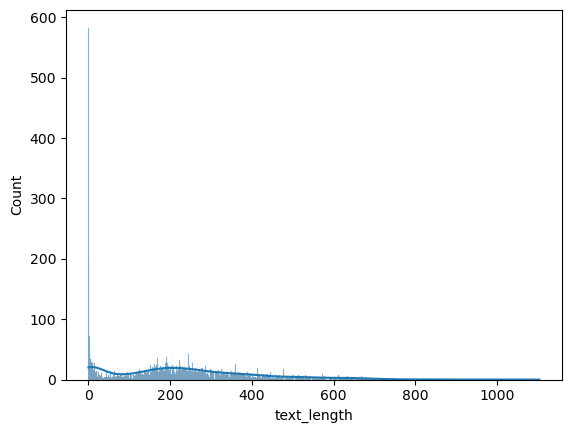

In [30]:
corpus['text_length']=corpus['cleaned_text'].apply(lambda x: len(x.split()))
sns.histplot(corpus['text_length'],kde=True,bins=1000)

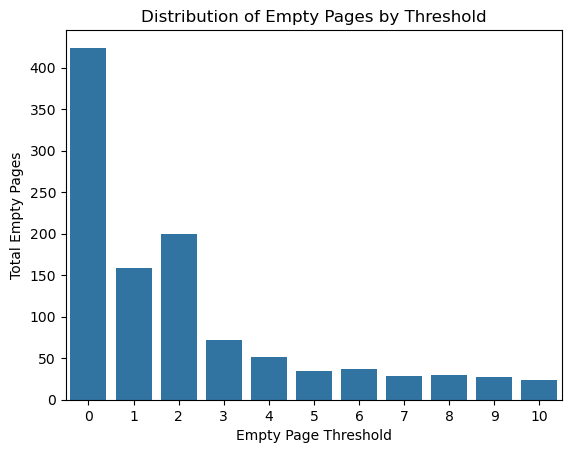

In [31]:
thresholds = range(0, 11)  
empty_pages_counts = []
cumsums=[]

for t in thresholds:
    count = corpus[corpus['text_length'] == t].shape[0]  
    cumsum= corpus[corpus['text_length'] <= t].shape[0]  
    empty_pages_counts.append(count)
    cumsums.append(cumsum)


df_plot = pd.DataFrame({
    'empty_page_threshold': thresholds,
    'total_empty_pages': empty_pages_counts
})


sns.barplot(x='empty_page_threshold', y='total_empty_pages', data=df_plot)
plt.xlabel("Empty Page Threshold")
plt.ylabel("Total Empty Pages")
plt.title("Distribution of Empty Pages by Threshold")
plt.show()

Text(0.5, 1.0, 'Distribution of Empty Pages by Threshold')

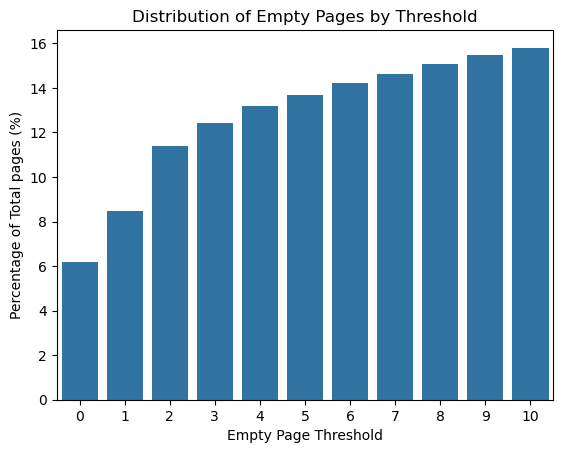

In [32]:
sns.barplot(x=thresholds, y=[(s/len(corpus))*100 for s in cumsums])
plt.xlabel("Empty Page Threshold")
plt.ylabel("Percentage of Total pages (%)")
plt.title("Distribution of Empty Pages by Threshold")


Choose 2 as standard emptyness thershold
### Thesholding

In [33]:
empty_pages=corpus[corpus['text_length']<2][['text_length','file_name']].groupby('file_name').count().reset_index().rename(columns={'text_length':'empty_pages'})
corpus=corpus.merge(empty_pages,on='file_name',how='left')
corpus


,file_name,page_number,cleaned_text,text_length,empty_pages
0,Divan_Prak10,1,ե ա բ,3,45.0
1,Divan_Prak10,2,,0,45.0
2,Divan_Prak10,3,,0,45.0
3,Divan_Prak10,4,,0,45.0
4,Divan_Prak10,5,,0,45.0
...,...,...,...,...,...
6873,ՑԵՂԱՍՊԱՆՈՒԹՅՈՒՆԸ-ՎԵՐԱՊՐԱԾՆԵՐԻ-ԾՆՆԴԱՎԱՅՐԵՐԸ-ԼԻԲ...,162,տեղանունների ցանկ սիվրիհիսար սուր սուրիա սպարթ...,115,5.0
6874,ՑԵՂԱՍՊԱՆՈՒԹՅՈՒՆԸ-ՎԵՐԱՊՐԱԾՆԵՐԻ-ԾՆՆԴԱՎԱՅՐԵՐԸ-ԼԻԲ...,163,ցեղասպանությունը վերապրածների ծննդավայրերը լիբ...,214,5.0
6875,ՑԵՂԱՍՊԱՆՈՒԹՅՈՒՆԸ-ՎԵՐԱՊՐԱԾՆԵՐԻ-ԾՆՆԴԱՎԱՅՐԵՐԸ-ԼԻԲ...,164,նշուսների հասար,2,5.0
6876,ՑԵՂԱՍՊԱՆՈՒԹՅՈՒՆԸ-ՎԵՐԱՊՐԱԾՆԵՐԻ-ԾՆՆԴԱՎԱՅՐԵՐԸ-ԼԻԲ...,165,ցեղասպանությունը վերապրածների ծննդավայրերը լիբ...,37,5.0


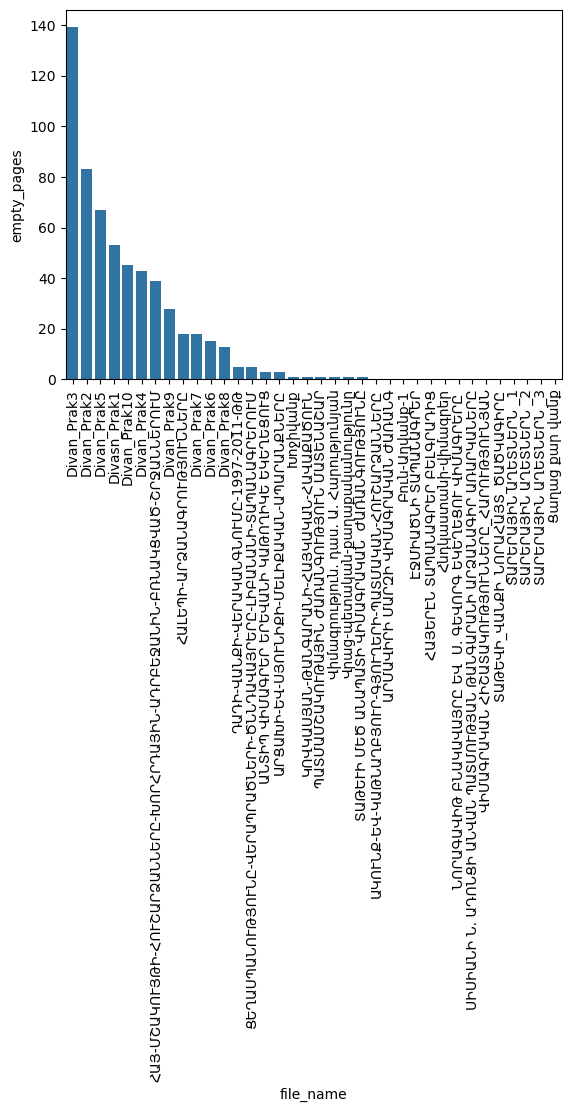

In [34]:
sorted_corpus=corpus[['file_name','empty_pages']].drop_duplicates().sort_values(by='empty_pages',ascending=False)
sns.barplot(x=sorted_corpus['file_name'],y=sorted_corpus['empty_pages'])
plt.xticks(rotation=90)
plt.show()

In [35]:
filtered_corpus=corpus[corpus['text_length']>2]
filtered_corpus

,file_name,page_number,cleaned_text,text_length,empty_pages
0,Divan_Prak10,1,ե ա բ,3,45.0
5,Divan_Prak10,6,աա շօշ շ.. իւ ի շօբթ ստ բ տ,9,45.0
6,Divan_Prak10,7,հհգիտությունների ազգային ակադեմիա հնագիտության...,21,45.0
7,Divan_Prak10,8,դ . գմդ . . դ տպագրվում է հ գաս հնագիտության և...,107,45.0
9,Divan_Prak10,10,ս. բարխուդարյանի ձեռագիր պրակիէջ ար ա. ևարավջա...,230,45.0
...,...,...,...,...,...
6872,ՑԵՂԱՍՊԱՆՈՒԹՅՈՒՆԸ-ՎԵՐԱՊՐԱԾՆԵՐԻ-ԾՆՆԴԱՎԱՅՐԵՐԸ-ԼԻԲ...,161,ցեղասպանությունը վերապրածների ծննդավայրերը լիբ...,343,5.0
6873,ՑԵՂԱՍՊԱՆՈՒԹՅՈՒՆԸ-ՎԵՐԱՊՐԱԾՆԵՐԻ-ԾՆՆԴԱՎԱՅՐԵՐԸ-ԼԻԲ...,162,տեղանունների ցանկ սիվրիհիսար սուր սուրիա սպարթ...,115,5.0
6874,ՑԵՂԱՍՊԱՆՈՒԹՅՈՒՆԸ-ՎԵՐԱՊՐԱԾՆԵՐԻ-ԾՆՆԴԱՎԱՅՐԵՐԸ-ԼԻԲ...,163,ցեղասպանությունը վերապրածների ծննդավայրերը լիբ...,214,5.0
6876,ՑԵՂԱՍՊԱՆՈՒԹՅՈՒՆԸ-ՎԵՐԱՊՐԱԾՆԵՐԻ-ԾՆՆԴԱՎԱՅՐԵՐԸ-ԼԻԲ...,165,ցեղասպանությունը վերապրածների ծննդավայրերը լիբ...,37,5.0


## Short text filtration

C:\Users\Kamal\AppData\Local\Temp\ipykernel_29644\1764509475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_corpus['max_token_length']=filtered_corpus['cleaned_text'].apply(lambda x: max([len(token) for token in x.split()]))


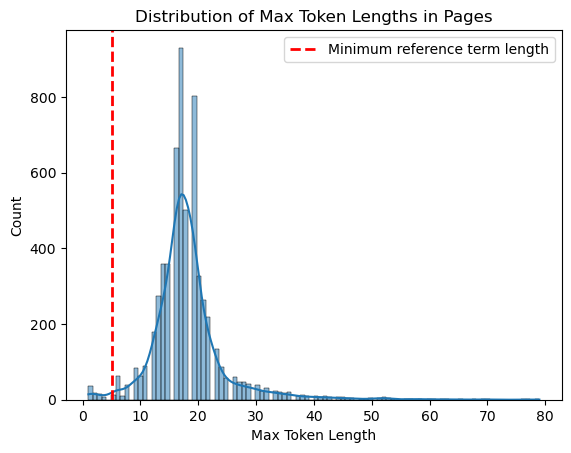

In [36]:
filtered_corpus['max_token_length']=filtered_corpus['cleaned_text'].apply(lambda x: max([len(token) for token in x.split()]))
sns.histplot(filtered_corpus['max_token_length'],kde=True,bins=100)
plt.xlabel('Max Token Length')
plt.title('Distribution of Max Token Lengths in Pages')
plt.axvline(x=5, color='red', linestyle='--', linewidth=2, label='Minimum reference term length')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Distribution of Reference Term Lengths')

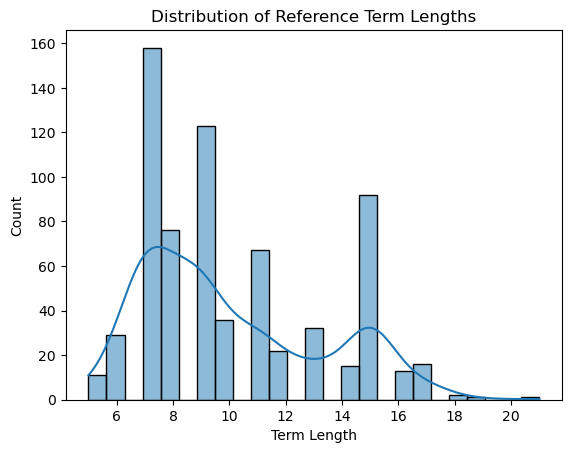

In [37]:
reference_terms=pd.read_excel('C:/Users/Kamal/OneDrive/Desktop/PDS/Copy of corpus_inscription_terms.xlsx',sheet_name='Terms with Examples')
reference_terms.dropna(subset='term',inplace=True)
reference_terms['term_length']=reference_terms['term'].apply(lambda x: max([len(token) for token in x.split()]))
sns.histplot(reference_terms['term_length'],kde=True,bins=25)
plt.xlabel('Term Length')
plt.title('Distribution of Reference Term Lengths')

In [38]:
reference_terms.describe()

,count_in_file,term_length
count,694.000000,694.000000
mean,1.445245,10.047550
std,2.535013,3.212402
min,1.000000,5.000000
25%,1.000000,7.000000
50%,1.000000,9.000000
75%,1.000000,12.000000
max,49.000000,21.000000


Given the distribution of the reference terms' lenghts, let's discard of the pages that have a max token length of 3

In [39]:
filtered_corpus=filtered_corpus[filtered_corpus['max_token_length']>3]
filtered_corpus

,file_name,page_number,cleaned_text,text_length,empty_pages,max_token_length
5,Divan_Prak10,6,աա շօշ շ.. իւ ի շօբթ ստ բ տ,9,45.0,4
6,Divan_Prak10,7,հհգիտությունների ազգային ակադեմիա հնագիտության...,21,45.0,16
7,Divan_Prak10,8,դ . գմդ . . դ տպագրվում է հ գաս հնագիտության և...,107,45.0,20
9,Divan_Prak10,10,ս. բարխուդարյանի ձեռագիր պրակիէջ ար ա. ևարավջա...,230,45.0,15
10,Divan_Prak10,11,հրատարակիչների կողմիյ սեծանուն հայագետ վիմագրա...,361,45.0,20
...,...,...,...,...,...,...
6872,ՑԵՂԱՍՊԱՆՈՒԹՅՈՒՆԸ-ՎԵՐԱՊՐԱԾՆԵՐԻ-ԾՆՆԴԱՎԱՅՐԵՐԸ-ԼԻԲ...,161,ցեղասպանությունը վերապրածների ծննդավայրերը լիբ...,343,5.0,16
6873,ՑԵՂԱՍՊԱՆՈՒԹՅՈՒՆԸ-ՎԵՐԱՊՐԱԾՆԵՐԻ-ԾՆՆԴԱՎԱՅՐԵՐԸ-ԼԻԲ...,162,տեղանունների ցանկ սիվրիհիսար սուր սուրիա սպարթ...,115,5.0,12
6874,ՑԵՂԱՍՊԱՆՈՒԹՅՈՒՆԸ-ՎԵՐԱՊՐԱԾՆԵՐԻ-ԾՆՆԴԱՎԱՅՐԵՐԸ-ԼԻԲ...,163,ցեղասպանությունը վերապրածների ծննդավայրերը լիբ...,214,5.0,21
6876,ՑԵՂԱՍՊԱՆՈՒԹՅՈՒՆԸ-ՎԵՐԱՊՐԱԾՆԵՐԻ-ԾՆՆԴԱՎԱՅՐԵՐԸ-ԼԻԲ...,165,ցեղասպանությունը վերապրածների ծննդավայրերը լիբ...,37,5.0,16


In [40]:
filtered_corpus[['file_name','page_number','cleaned_text']].to_json('filtered_corpus.jsonl',orient='records',lines=True,force_ascii=False)

## TF-IDF cleaning

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus_texts = filtered_corpus['cleaned_text'].tolist()
vectorizer = TfidfVectorizer(
    min_df=2,      # ignore words that appear in fewer than 2 documents
    max_df=0.7,    # ignore words that appear in more than 70% of documents
    ngram_range=(1,2),  # unigrams and bigrams
    token_pattern=r'\b[\u0530-\u058F]+\b'  # match only Armenian letters, ignore digits
)
tfidf_matrix = vectorizer.fit_transform(corpus_texts)


In [17]:
vocab = vectorizer.get_feature_names_out()
print("Number of filtered tokens:", len(vocab))
print(vocab[:20])


Number of filtered tokens: 179821
['՛ս' 'ա' 'ա ա' 'ա աա' 'ա աան' 'ա աբաս' 'ա աբրահամ' 'ա աբրահամյան'
 'ա աբրահամյանը' 'ա աբրահամյանի' 'ա ագ' 'ա ագարակ' 'ա ադամյան' 'ա ազգ'
 'ա ազգային' 'ա աէ' 'ա աը' 'ա աթ' 'ա աթան' 'ա աթո']


## Analysis of manual extractions

In [20]:
reference_terms=pd.read_excel('C:/Users/Kamal/OneDrive/Desktop/PDS/Copy of corpus_inscription_terms.xlsx',sheet_name='Terms with Examples')
reference_terms.dropna(subset=['term'],inplace=True) 
reference_terms.drop_duplicates(subset=['term','example'],inplace=True)
reference_terms['term']=reference_terms['term'].apply(lambda x: clean_text(x))
reference_terms.head()

,term,file,count_in_file,example
0,տապանագիր,Divan_Prak10.txt,2,"նք, գերեզմանոց - Լմբատավանք, գերեզմանոց տապան..."
2,սեպագիր,Divan_Prak4.txt,1,"ն րերդշեն, որը գրավել է ուրարտական Ռուսա թագավ..."
3,ալս գլուղում պահպանվել են արձանագրություն,Divan_Prak3.txt,1,ԵՒ ՈՎՍԵՓԱ. ԹՎ. 2։ (1251) Ծանոթ. Գծագիրն ստացե...
4,ալս մատուռի մեջ անցլալում եղել են չորս ձեռագիր,Divan_Prak5.txt,1,"զրին. փոք- րիկ մատուռ է, որի բեմի տակ դամբարան..."
5,ամփոփ տեղեկագիր,ՀԱԼԵՊԻ-ԱՐՁԱՆԱԳՐՈՒԹՅՈՒՆՆԵՐԸ.txt,2,"., նշվ. աշխ., էջ 310։ 113 Գապպէնճեան Գ., նշվ...."


<Axes: xlabel='term', ylabel='Count'>

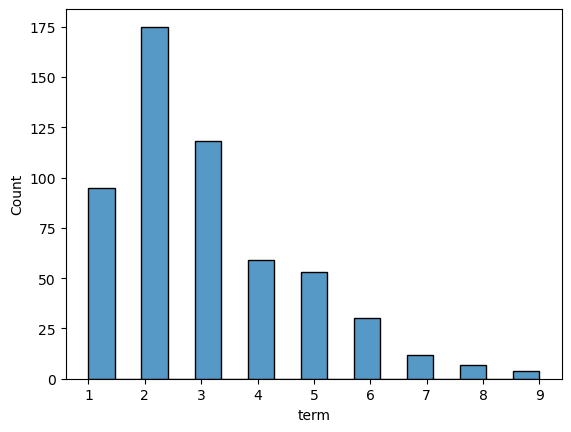

In [21]:
sns.histplot(x=reference_terms['term'].drop_duplicates().apply(lambda x: len(x.split())))

In [22]:
unique_terms=pd.read_excel('C:/Users/Kamal/OneDrive/Desktop/PDS/Copy of corpus_inscription_terms.xlsx',sheet_name='Unique Terms')
unique_terms.drop(columns=['Unnamed: 2'],inplace=True)
unique_terms.dropna(inplace=True)
unique_terms

,term,total_count
0,հիշատակագրություն,83
1,արձանագիր,35
2,հիշատակագիր,30
3,արձանագրություն,26
4,ձեռագիր,26
...,...,...
552,խնդրագիր,1
555,վայելչագիր,1
556,բառ պատուագիր,1
567,ապագիր,1


<Axes: xlabel='term', ylabel='Count'>

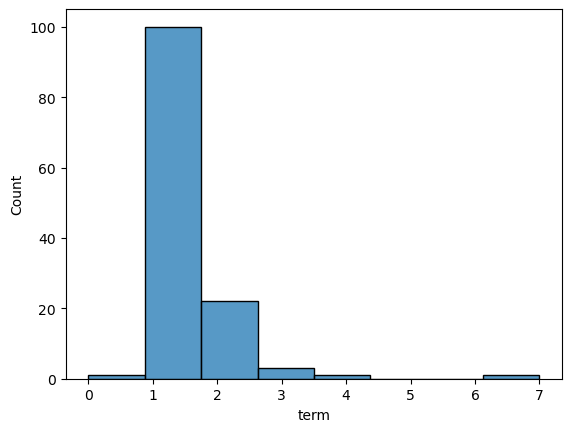

In [23]:
sns.histplot(x=unique_terms['term'].drop_duplicates().apply(lambda x: len(x.split())))

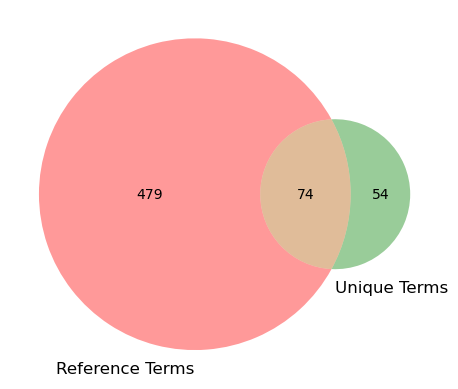

In [26]:
from matplotlib_venn import venn2
set_ref=set(reference_terms['term'])
set_unique=set(unique_terms['term'])
venn2([set_ref, set_unique], set_labels=("Reference Terms", "Unique Terms"))